In [1]:
import jax
from jax import random
from jax import numpy as jnp

from localdynamics import derivative, local_dynamics
from localdynamics.plotting import plot

from matplotlib import pyplot as plt
import matplotlib

jax.config.update('jax_platforms', 'cpu')
jax.config.update("jax_default_device", jax.devices('cpu')[0])

# Generate dummy data

In [2]:
def rational_quadratic(x, s=1.0, alpha=1.0, l=1.0):

    return s*(1+x**2/(2*alpha*l**2))**-alpha


def generate_covariance(ts, kernel):

    C = kernel(ts[:,jnp.newaxis] - ts[jnp.newaxis])

    return C


def gaussian_process(key, time_dim, neuron_dim, trial_dim=1, kernel=rational_quadratic, cholesky_epsilon=10**-5, t_max=10, **kwargs):

    ts = jnp.linspace(0, t_max, time_dim)

    C = generate_covariance(ts, kernel)

    L = jnp.linalg.cholesky(C+cholesky_epsilon*jnp.eye(time_dim))

    latent_gaussians = random.normal(key=key, shape=(trial_dim, time_dim, neuron_dim))

    gp = jnp.einsum('ti,kin->ktn', L, latent_gaussians)

    return ts, gp, C, L

2D Plane: t=(1001, 1), x=(1000, 100)
2D Plane+Noise: t=(1001, 1), x=(1000, 100)
2D Plane+GP Noise: t=(1001, 1), x=(1000, 100)
2D Cylinder: t=(1001, 1), x=(1000, 100)
100D Gaussian: t=(1001, 1), x=(1000, 100)
100D Process: t=(1001, 1), x=(1000, 100)


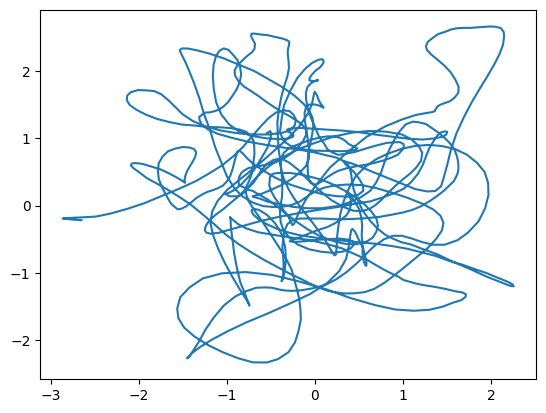

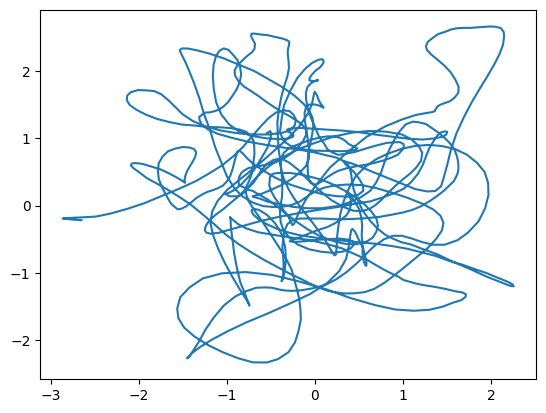

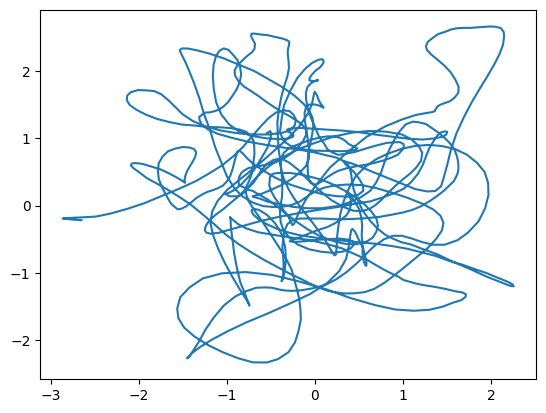

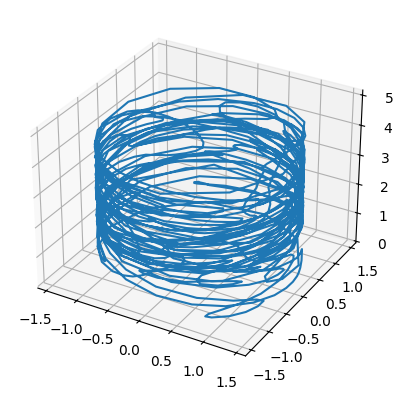

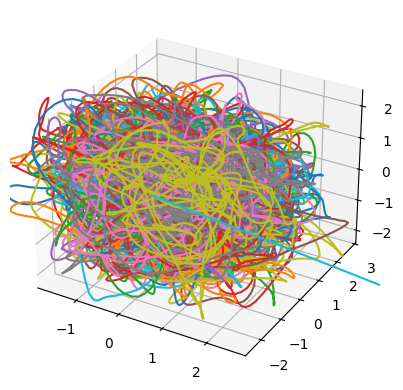

In [64]:
def get_data(key, time_dim):

    #ts = jnp.linspace(0, jnp.pi*2, time_dim)
    
    _, gp, _, _ = gaussian_process(key, time_dim, 2, 1, t_max=100)
    
    gp = gp * 3
    
    gp = gp + random.uniform(random.key(1), [gp.shape[0], 1, gp.shape[-1]], minval=0, maxval=jnp.pi*2)
    
    xs = jnp.stack([jnp.cos(gp[..., 0]), jnp.sin(gp[..., 0])], axis=-1)
    zs = gp[..., 1:]*2
        
    data = jnp.concatenate([xs, zs], axis=-1)
    
    data = data / jnp.std(data, axis=(0, 1), keepdims=True)
    
    #data = np.concatenate([np.tile(xs, (trial_dim, 1, 1)), np.tile(zs, (1, time_dim))[..., np.newaxis]], axis=-1)
    
    return data

def cylinder_data(key, time_dim, neuron_dim):
    
    key, subkey = random.split(key)
    ts_cylinder, data_cylinder = jnp.linspace(0, 1, 50), get_data(subkey, time_dim)[0]
    
    fig = plt.figure()
    ax =  fig.add_subplot(111, projection='3d')
    ax.plot(*data_cylinder.T)
    
    key, subkey = random.split(key)
    U , _, _ = jnp.linalg.svd(random.normal(subkey, (neuron_dim, neuron_dim)), full_matrices=False)
    data_cylinder = data_cylinder @ U[:3]
    
    key, subkey = random.split(key)
    data_cylinder = data_cylinder #+ random.normal(subkey, data_cylinder.shape)*0.3
    
    return data_cylinder

def gaussian_data(key, time_dim, neuron_dim):
    
    return random.normal(key=key, shape=(time_dim, neuron_dim))

def plannar_data(key, time_dim, neuron_dim, noise_magnitude=0.0, smooth_noise_magnitude=0.0):
    
    _, gp, _, _ = gaussian_process(key, time_dim, 2, 1, t_max=100)
    
    gp = gp[0]
    
    fig = plt.figure()
    ax =  fig.add_subplot(111)
    ax.plot(*gp.T)
    
    key, subkey = random.split(key)
    U , _, _ = jnp.linalg.svd(random.normal(subkey, (neuron_dim, neuron_dim)), full_matrices=False)
    data_plane = gp @ U[:2]
    
    key, subkey = random.split(key)
    data_plane = data_plane + random.normal(subkey, data_plane.shape) * noise_magnitude / jnp.sqrt(neuron_dim)
    
    key, subkey = random.split(key)
    _, gp, _, _ = gaussian_process(key, time_dim, neuron_dim, 1, t_max=100) ; gp = gp[0]
    data_plane = data_plane + smooth_noise_magnitude * gp / jnp.sqrt(neuron_dim)
    
    return data_plane

def gp_data(key, time_dim, neuron_dim):
    
    _, gp, _, _ = gaussian_process(key, time_dim, neuron_dim, 1, t_max=100)
    
    fig = plt.figure()
    ax =  fig.add_subplot(111, projection='3d')
    ax.plot(*gp[:3].T)

    return gp[0]

time_dim, neuron_dim = 1000, 100
key = random.PRNGKey(1)

dataset_names = ['2D Plane', '2D Plane+Noise', '2D Plane+GP Noise', '2D Cylinder', f'{neuron_dim}D Gaussian', f'{neuron_dim}D Process']
xs = [plannar_data(key, time_dim, neuron_dim), plannar_data(key, time_dim, neuron_dim, 0.1), plannar_data(key, time_dim, neuron_dim, 0.0, 0.1), cylinder_data(key, time_dim, neuron_dim), gaussian_data(key, time_dim, neuron_dim), gp_data(key, time_dim, neuron_dim)]
ts = [jnp.linspace(0, 1, time_dim+1)[:, jnp.newaxis]]*len(dataset_names)

for d, t, x in zip(dataset_names, ts, xs):
    print(f'{d}: t={t.shape}, x={x.shape}')

# Compute the singular values

The analysis depends on three key hyperparameters: the number of neighboring points, whether we rescale the dynamics to unit length, and whether if scale the dynamics by their distance to the central point.

In [65]:
# Finite difference dynamics
dxs_dts = [derivative(t[1:]-t[:-1], x, accuracy=2) for t, x in zip(ts, xs)]

max_neighbors = 50

# Dynamics near each point (i.e. local dynamics)
# number_of_neighbors scales O(number_of_neighbors)
local_dxs_dts = [local_dynamics(x, dx_dt, number_of_neighbors=max_neighbors, unit_length=True, distance_scaling=None) for x, dx_dt in zip(xs, dxs_dts)]
local_xs = [local_dynamics(x, x, number_of_neighbors=max_neighbors, unit_length=False, distance_scaling=None) - x[..., jnp.newaxis, :] for x, dx_dt in zip(xs, dxs_dts)]

# Singular values of the local dynamics
# Fix the number of neighbors ? (sample)
sv_local_dxs_dts = list(zip(*[[jnp.linalg.svd(local_dx_dt[..., :k, :], full_matrices=False)[1] for local_dx_dt in local_dxs_dts] for k in range(1, max_neighbors, 1)]))

# We also compute the singular values of the full data
sv_xs = [jnp.linalg.svd(x, full_matrices=False)[1] for x in local_xs]

# Plotting

In [90]:
# data_set, nb_neighbors, point, sv
def plot_sv_barcode(axs, svs, cmap=matplotlib.colormaps['Blues']):
            
    for axi, (ax, sv) in enumerate(zip(axs, svs)):
        
        # nb_neigh, sv
        '''sv = [jnp.median(s/jnp.max(s, axis=1, keepdims=True), axis=0) for s in sv]
        max_s_len = max([s.shape[0] for s in sv])
        sv = jnp.stack([jnp.concatenate([s, jnp.full((max_s_len - s.shape[0],), jnp.nan)]) for s in sv])
        sv = sv.T
        sv = sv/jnp.nanmax(sv, axis=(0,))'''
        max_s_len = max([s.shape[1] for s in sv])
        sv = jnp.stack([jnp.concatenate([s, jnp.full((s.shape[0], max_s_len - s.shape[1]), jnp.nan)], axis=-1) for s in sv])

        sv = sv / jnp.nanmax(sv, axis=-1, keepdims=True)
        #sv = sv/jnp.nanmax(sv, axis=(0,))
        sv = jnp.nanquantile(sv, 1.0, axis=-2)
        sv = sv.T
        
        for si, s in enumerate(sv):
                        
            #s = s[1:] - s[:-1]
            #s = s[1:] - s[:-1]
            
            s = s#[:50]
            
            max_ = jnp.nanquantile(s, 0.99, method='nearest')
            max_ = jnp.nanmax(s)
            max_i = jnp.argwhere(s == max_)[0][0]
            
            ax.scatter(max_i+1, max_, color='red', zorder=5)
            
            ax.plot(jnp.arange(s.shape[0])+1, s, '-o', color=cmap((si+1)/len(sv)) if si != 0 else (0.2, 0.9, 0.4), zorder=4)     
            
            
def plot_srank(axs, svs):
    
    for axi, (ax, sv) in enumerate(zip(axs, svs)):
        
        max_s_len = max([s.shape[1] for s in sv])
        sv = jnp.stack([jnp.concatenate([s, jnp.full((s.shape[0], max_s_len - s.shape[1]), jnp.nan)], axis=-1) for s in sv])

        sv = sv / jnp.nanmax(sv, axis=-1, keepdims=True)
        #sv = sv/jnp.nanmax(sv, axis=(0,))
        sv = jnp.nanquantile(sv, 1.0, axis=-2)
        sv_ = jnp.nansum(sv**2, axis=-1)
        
        #sv  = jnp.exp(-jnp.nansum(jnp.log(sv/sv_[..., jnp.newaxis])*sv/sv_[..., jnp.newaxis], axis=-1))
        #sv = sv_
        sv = jnp.argmax(jnp.abs((jnp.arange(sv.shape[-1])[jnp.newaxis] - 1)/(sv.shape[-1] - 1) + (sv - sv[-1:])/(sv[:1] - sv[-1:]) - 1), axis=-1)/jnp.sqrt(2) - 1
        
        #sv = sv[1:] - sv[:-1]
        
        ax.plot(jnp.arange(sv.shape[0])+1, sv, '-o', color='red')
        
        ax.axhline(2.0, linestyle='--', label='True dim')
        
        ax.legend()
        
        ax.set_xlabel('# Neighbors'), ax.set_ylabel('sRank')
            
            

(49, 49)
(49, 49)
(49, 49)
(49, 49)
(49, 49)
(49, 49)


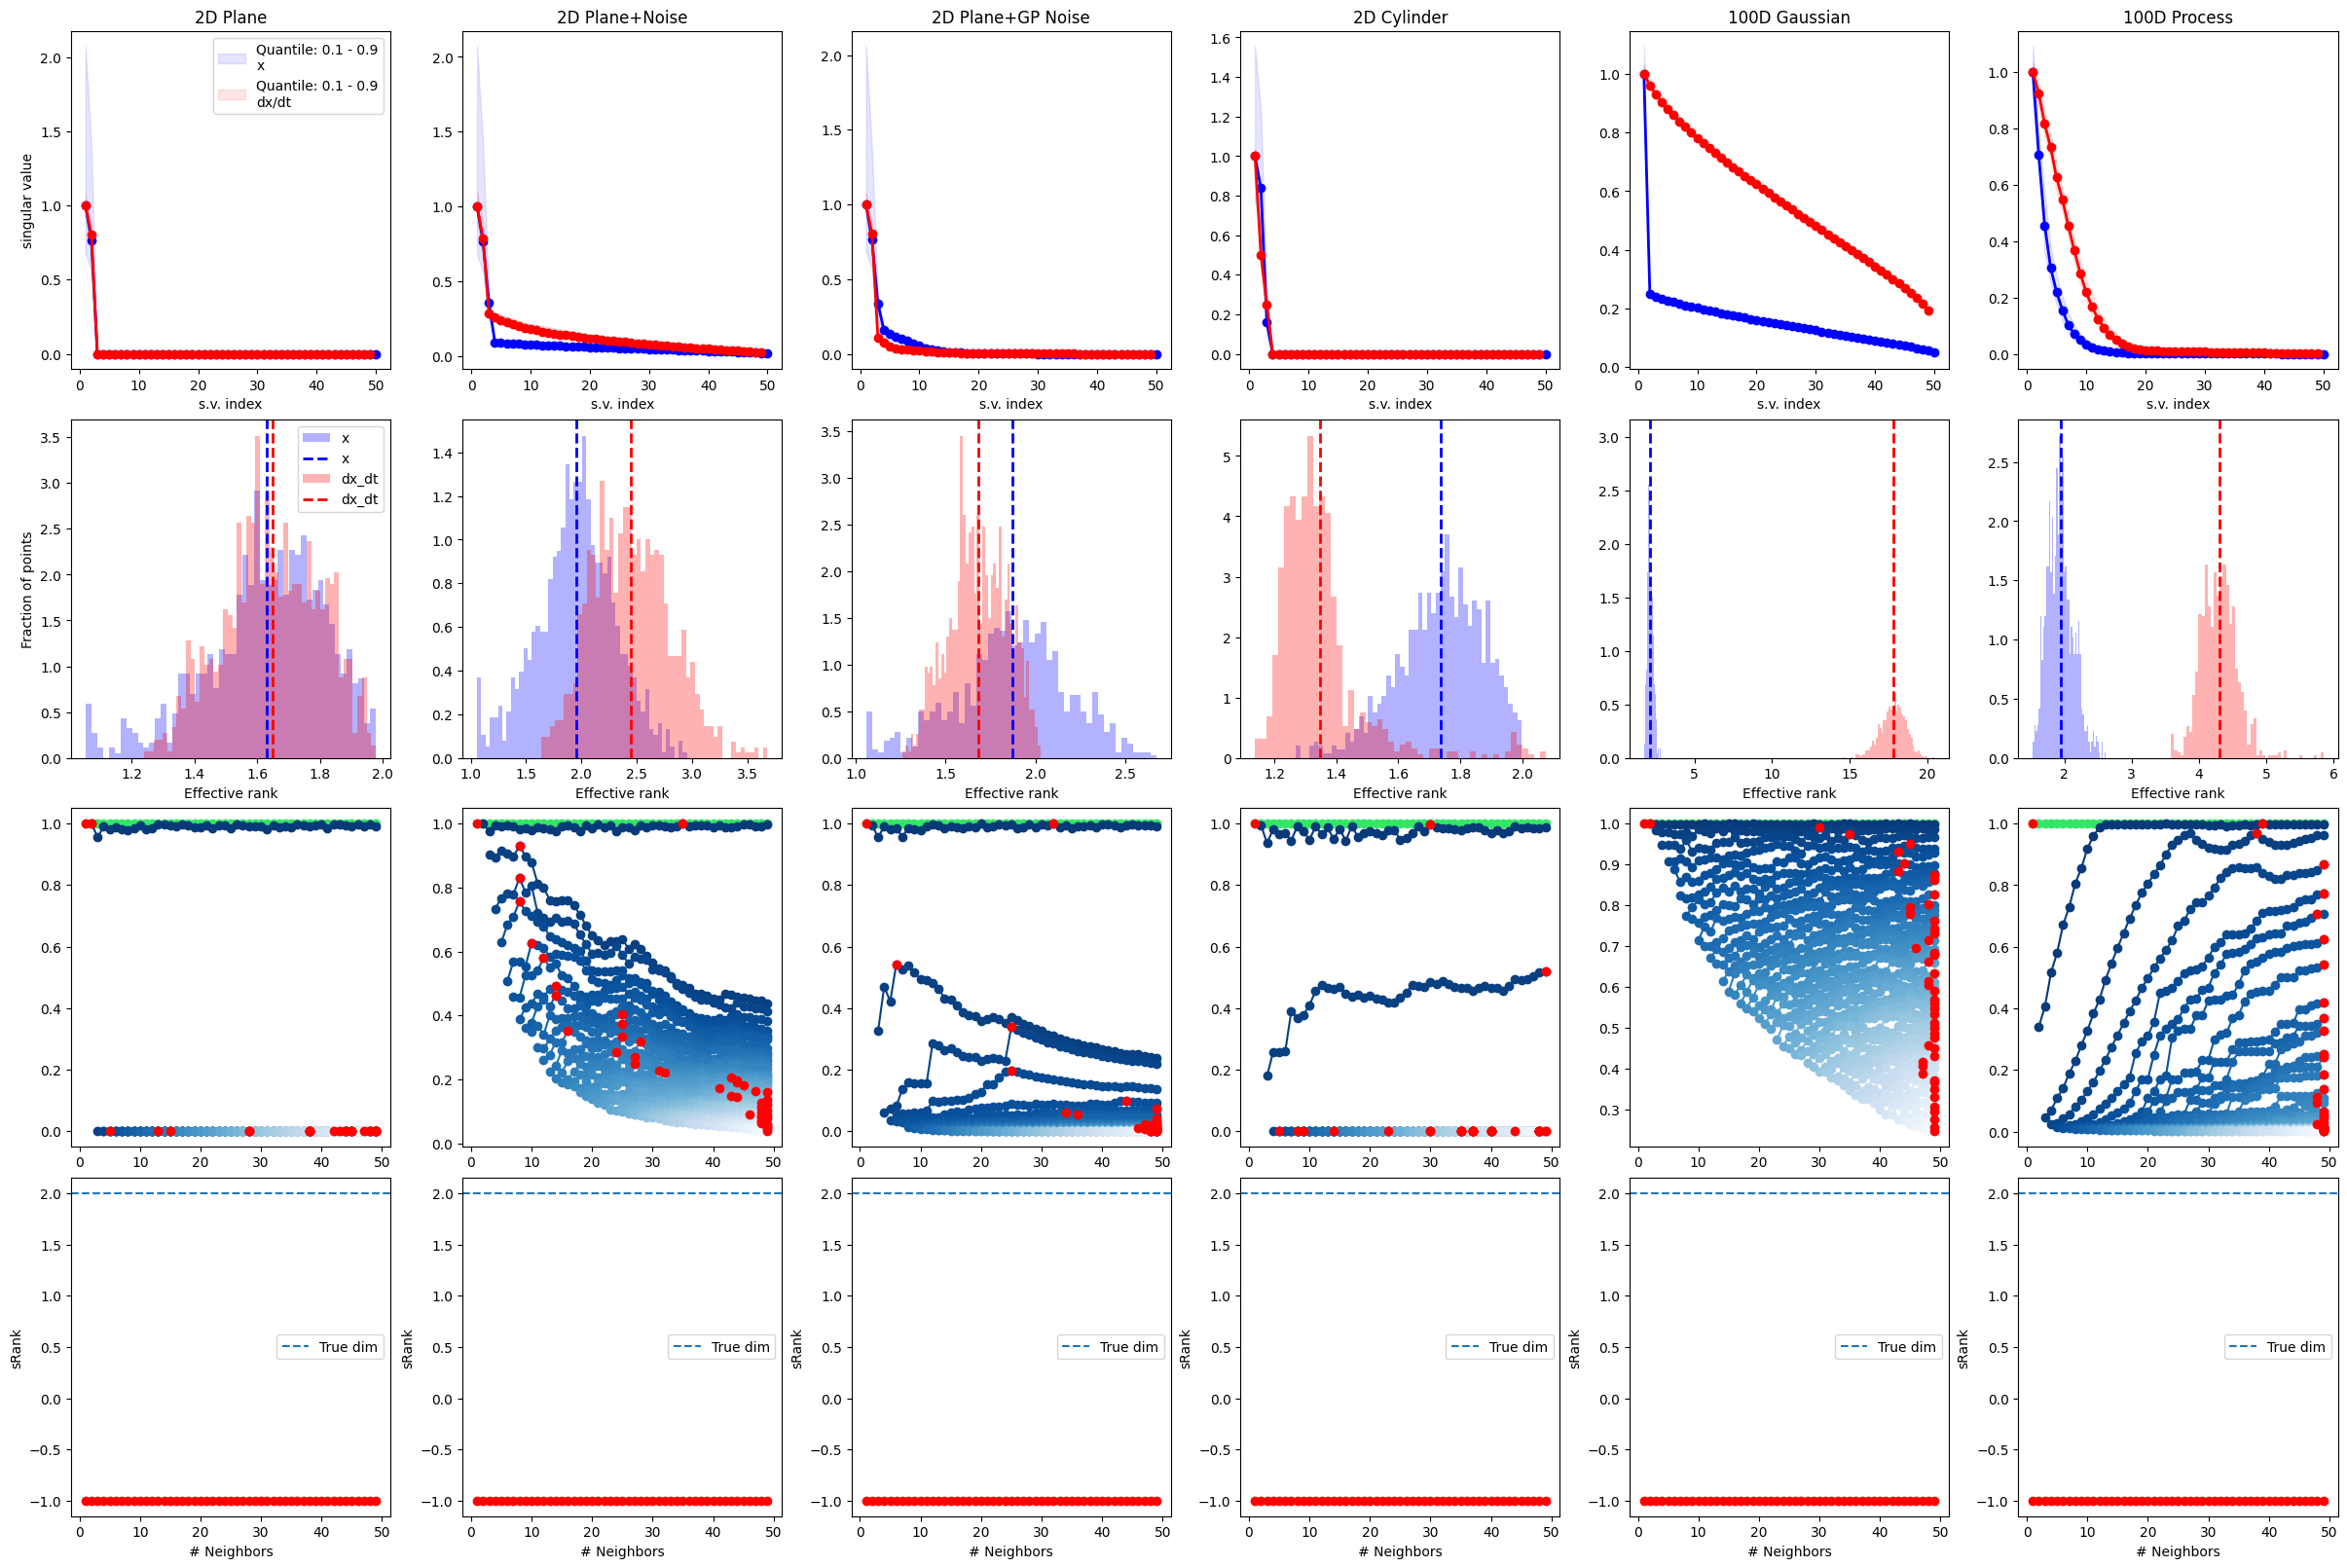

In [91]:
fig, axs = plot.get_axes_grid(cols=len(dataset_names), rows=4, dpi=100)

for d, ax in zip(dataset_names, axs): ax[0].set_title(d)
    
plot.plot_spectra(axs[:, 0], sv_xs, log=False, normalize=True, quantile=0.1, plotall=False, color='blue', label='x')

plot.plot_spectra(axs[:, 0], [s[-1] for s in sv_local_dxs_dts], log=False, normalize=True, quantile=0.1, plotall=False, color='red', label='dx/dt')

plot.plot_effective_rank(axs[:, 1], sv_xs, color='blue', label='x')
plot.plot_effective_rank(axs[:, 1], [s[-1] for s in sv_local_dxs_dts], color='red', label='dx_dt')

plot_sv_barcode(axs[:, 2], sv_local_dxs_dts, cmap=matplotlib.colormaps['Blues_r'])
plot_srank(axs[:, 3], sv_local_dxs_dts)

plt.show()

In [82]:
sv = jnp.array([1, 1]+[0.1]*100)

erank = lambda s: jnp.exp(-jnp.sum(jnp.log(10**-8+s/jnp.sum(s, axis=-1, keepdims=True))*s/jnp.sum(s, axis=-1, keepdims=True), axis=-1))

print(erank(sv))

81.75497
